## 5.11　专题：k-means聚类

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set() # 绘图风格
import numpy as np

### 5.11.1 k-means简介

<ul>k-means 算法在不带标签的多维数据集中寻找确定数量的簇。最优的聚类结果需要符合以
下两个假设。
    <li>“簇中心点”（cluster center）是属于该簇的所有数据点坐标的算术平均值。</li>
    <li>一个簇的每个点到该簇中心点的距离，比到其他簇中心点的距离短。</li>
</ul>

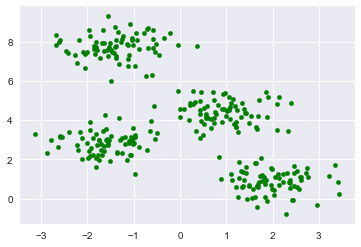

In [2]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=20, color='green');

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

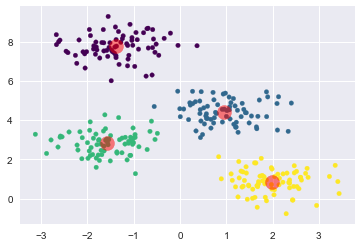

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=20, cmap='viridis')
center = kmeans.cluster_centers_
plt.scatter(center[:, 0], center[:, 1], c='red', s=200, alpha=0.5);

### 5.11.2 k-means算法：期望最大化

期望最大化（expectation-maximization，E-M）是一种非常强大的算法，应用于数据科学
的很多场景中。k-means 是该算法的一个非常简单并且易于理解的应用，下面将简单介绍
E-M 算法。简单来说，期望最大化方法包含以下步骤。

<p>(1) 猜测一些簇中心点.</p>
<p>(2) 重复直至收敛.
a. 期望步骤（E-step）：将点分配至离其最近的簇中心点。
b. 最大化步骤（M-step）：将簇中心点设置为所有点坐标的平均值。

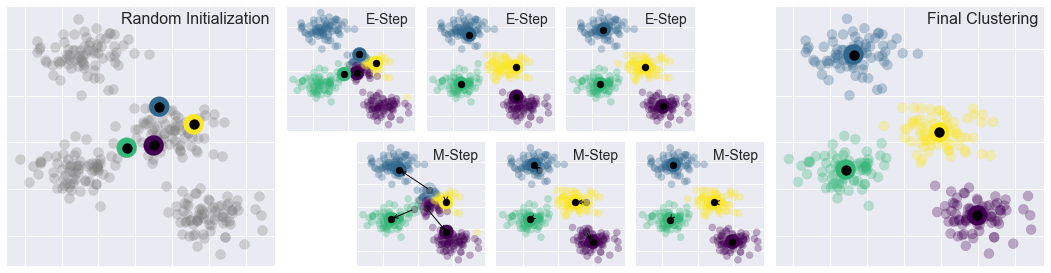

In [5]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import pairwise_distances_argmin

# 生成数据点
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
# s随机产生四个簇中心
rng = np.random.RandomState(42)
centers = [0, 4] + rng.randn(4, 2)

# 画出数据点
def draw_points(ax, c, factor=1):
    ax.scatter(X[:, 0], X[:, 1], c=c, cmap='viridis',
               s=50 * factor, alpha=0.3)
    
# 画出簇中心
def draw_centers(ax, centers, factor=1, alpha=1.0):
    ax.scatter(centers[:, 0], centers[:, 1],
               c=np.arange(4), cmap='viridis', s=200 * factor,
               alpha=alpha)
    ax.scatter(centers[:, 0], centers[:, 1],
               c='black', s=50 * factor, alpha=alpha)

def make_ax(fig, gs):
    ax = fig.add_subplot(gs)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    return ax

fig = plt.figure(figsize=(15, 4))
gs = plt.GridSpec(4, 15, left=0.02, right=0.98, bottom=0.05, top=0.95, wspace=0.2, hspace=0.2)
ax0 = make_ax(fig, gs[:4, :4])
ax0.text(0.98, 0.98, "Random Initialization", transform=ax0.transAxes,
         ha='right', va='top', size=16)
draw_points(ax0, 'gray', factor=2)
draw_centers(ax0, centers, factor=2)

for i in range(3):
    ax1 = make_ax(fig, gs[:2, 4 + 2 * i:6 + 2 * i])
    ax2 = make_ax(fig, gs[2:, 5 + 2 * i:7 + 2 * i])
    
    # E-step
    y_pred = pairwise_distances_argmin(X, centers)
    draw_points(ax1, y_pred)
    draw_centers(ax1, centers)
    
    # M-step
    new_centers = np.array([X[y_pred == i].mean(0) for i in range(4)])
    draw_points(ax2, y_pred)
    draw_centers(ax2, centers, alpha=0.3)
    draw_centers(ax2, new_centers)
    for i in range(4):
        ax2.annotate('', new_centers[i], centers[i],
                     arrowprops=dict(arrowstyle='->', linewidth=1))
        
    
    # Finish iteration
    centers = new_centers
    ax1.text(0.95, 0.95, "E-Step", transform=ax1.transAxes, ha='right', va='top', size=14)
    ax2.text(0.95, 0.95, "M-Step", transform=ax2.transAxes, ha='right', va='top', size=14)


# Final E-step    
y_pred = pairwise_distances_argmin(X, centers)
axf = make_ax(fig, gs[:4, -4:])
draw_points(axf, y_pred, factor=2)
draw_centers(axf, centers, factor=2)
axf.text(0.98, 0.98, "Final Clustering", transform=axf.transAxes,
         ha='right', va='top', size=16)


fig.savefig('figures/05.11-expectation-maximization.png')

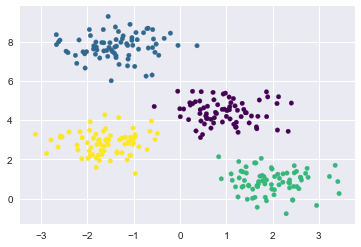

In [6]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1: Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a: Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b: Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
        
        # 2c: Check for coverage
        if np.all(centers == new_centers):
            break
        centers = new_centers
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=20, cmap='viridis');

#### 使用期望最大化算法时的注意事项在使用期望最大化算法时，需要注意几个问题。
<p>可能不会达到全局最优结果</p>

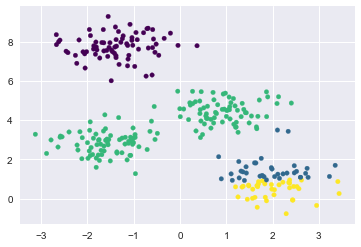

In [7]:
# 使用了随机种子
centers, labels = find_clusters(X, 4, rseed=0) 
plt.scatter(X[:, 0], X[:, 1], c=labels, s=20, cmap='viridis');

#### 簇数量必须事先定好:

k-means 还有一个显著的问题：你必须告诉该算法簇数量，因为它无法从数据中自动学
习到簇的数量。

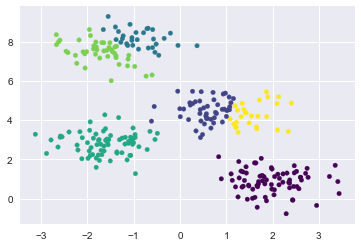

In [8]:
labels = KMeans(n_clusters=6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=20, cmap='viridis');

#### k-means 算法只能确定线性聚类边界

<p>k-means 的基本模型假设（与其他簇的点相比，数据点更接近自己的簇中心点）表明，
当簇中心点呈现非线性的复杂形状时，该算法通常不起作用。</p>
<p>k-means 聚类的边界总是线性的，这就意味着当边界很复杂时，算法会失效。用下面的
数据来演示 k-means 算法得到的簇标签</p>

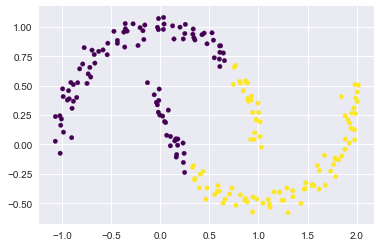

In [9]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)
labels = KMeans(n_clusters=2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=20, cmap='viridis');

D:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


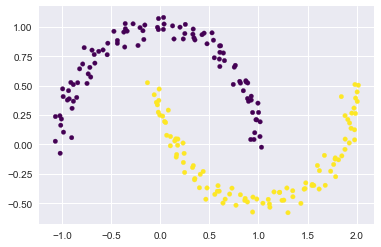

In [10]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=20, cmap='viridis');

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # for plot styling
import numpy as np

from ipywidgets import interact
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets.samples_generator import make_blobs

def plot_kmeans_interactive(min_clusters=1, max_clusters=6):
    X, y = make_blobs(n_samples=300, centers=4,
                      random_state=0, cluster_std=0.60)

    def plot_points(X, labels, n_clusters):
        plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis',
                    vmin=0, vmax=n_clusters - 1);
    
    def plot_centers(centers):
        plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c=np.arange(centers.shape[0]),
                    s=200, cmap='viridis')
        plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c='black', s=50)
    
    def _kmeans_step(frame=0, n_clusters=4):
        rng = np.random.RandomState(2)
        labels = np.zeros(X.shape[0])
        centers = rng.randn(n_clusters, 2)

        nsteps = frame // 3

        for i in range(nsteps + 1):
            old_centers = centers
            if i < nsteps or frame % 3 > 0:
                labels = pairwise_distances_argmin(X, centers)

            if i < nsteps or frame % 3 > 1:
                centers = np.array([X[labels == j].mean(0)
                                    for j in range(n_clusters)])
                nans = np.isnan(centers)
                centers[nans] = old_centers[nans]

        # plot the data and cluster centers
        plot_points(X, labels, n_clusters)
        plot_centers(old_centers)

        # plot new centers if third frame
        if frame % 3 == 2:
            for i in range(n_clusters):
                plt.annotate('', centers[i], old_centers[i], 
                             arrowprops=dict(arrowstyle='->', linewidth=1))
            plot_centers(centers)

        plt.xlim(-4, 4)
        plt.ylim(-2, 10)

        if frame % 3 == 1:
            plt.text(3.8, 9.5, "1. Reassign points to nearest centroid",
                     ha='right', va='top', size=14)
        elif frame % 3 == 2:
            plt.text(3.8, 9.5, "2. Update centroids to cluster means",
                     ha='right', va='top', size=14)
    
    return interact(_kmeans_step, frame=[0, 50],
                    n_clusters=[min_clusters, max_clusters])

plot_kmeans_interactive();

interactive(children=(Dropdown(description='frame', options=(0, 50), value=0), Dropdown(description='n_clusters', options=(1, 6), value=1), Output()), _dom_classes=('widget-interact',))

## 5.11.3　案例

### 1. 案例1：用k-means算法处理手写数字

In [11]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [12]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

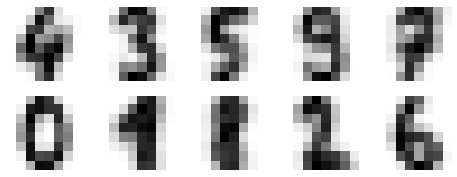

In [13]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi,center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [14]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [15]:
# 检查无监督聚类算法在查找相似数字时的准确性了：
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

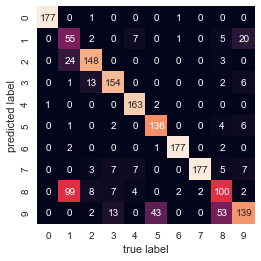

In [16]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [17]:
from sklearn.manifold import TSNE

# projection the data: this step will take several seconds
tsen = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsen.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9326655537006121

D:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\datasets\base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
D:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\datasets\base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]


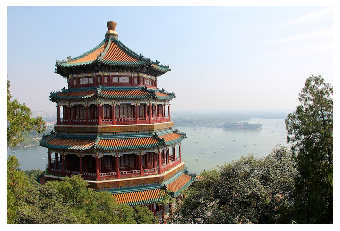

In [18]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

In [19]:
china.shape

(427, 640, 3)

In [20]:
data = china / 255.0
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

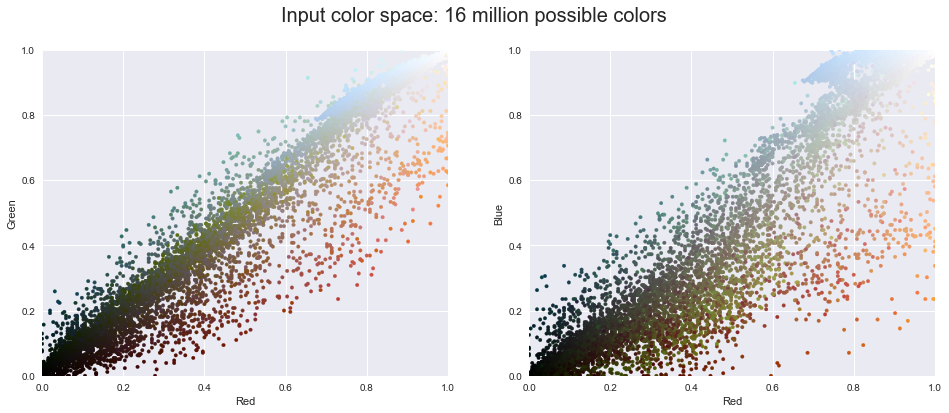

In [21]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))
    
    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))
    
    fig.suptitle(title, size=20)

plot_pixels(data, title='Input color space: 16 million possible colors');

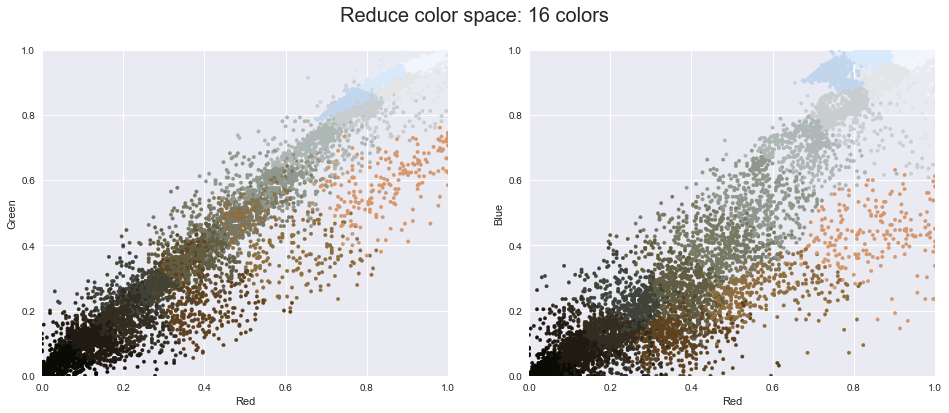

In [22]:
import warnings; warnings.simplefilter('ignore') # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors, title='Reduce color space: 16 colors')

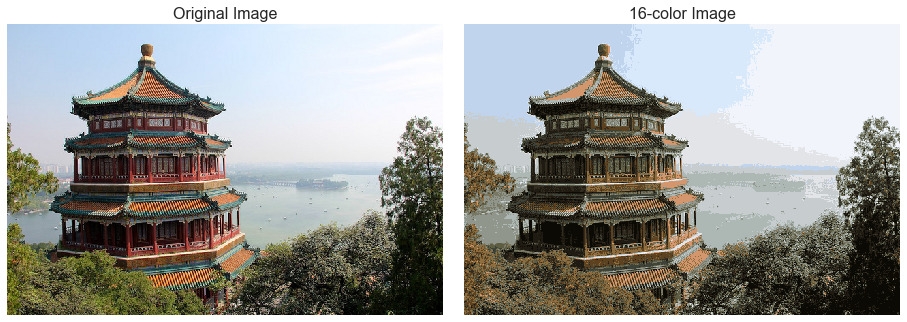

In [23]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);